In [ ]:
import Pkg
using Pkg

In [ ]:
Pkg.add(["CausalInference", "Graphs", "GraphRecipes", "Plots", "StatsPlots", "DataFrames", "GLM", "StatsModels", "Random", "CSV", "Printf"])

In [13]:
using CausalInference, Graphs, GraphRecipes, Plots, StatsPlots, DataFrames, GLM, StatsModels, Random, CSV, Printf

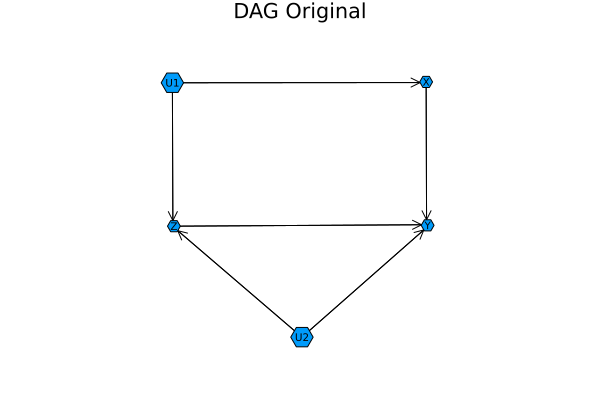

In [ ]:
#crear el DAG
node_labels_orig = ["U1", "U2", "X", "Y", "Z"]
nodes_orig = Dict(l => i for (i, l) in enumerate(node_labels_orig))

g_original = DiGraph(5)
add_edge!(g_original, nodes_orig["U1"], nodes_orig["X"]); add_edge!(g_original, nodes_orig["U1"], nodes_orig["Z"]);
add_edge!(g_original, nodes_orig["U2"], nodes_orig["Y"]); add_edge!(g_original, nodes_orig["U2"], nodes_orig["Z"]);
add_edge!(g_original, nodes_orig["X"], nodes_orig["Y"]); add_edge!(g_original, nodes_orig["Z"], nodes_orig["Y"]);

node_styles = Dict(nodes_orig["U1"] => :dash, nodes_orig["U2"] => :dash)

Plots.plot(g_original, names=node_labels_orig, node_style=node_styles, curves=false, 
     title="DAG Original")

In [ ]:
Random.seed!(111); 
n_samples = 100000;
true_effect_original = 1.0


U1 = randn(n_samples); U2 = randn(n_samples)
Z  = 0.6 * U1 + 0.5 * U2 .+ randn(n_samples)
X  = 0.8 * U1 .+ randn(n_samples)
Y  = true_effect_original .* X + 0.4 .* Z + 0.9 .* U2 .+ randn(n_samples)
df_original = DataFrame(X=X, Y=Y, Z=Z)

Row,X,Y,Z
,Float64,Float64,Float64
1,-2.99577,-2.18651,-1.16088
2,0.794865,0.541848,-0.605976
3,0.0812642,1.79313,0.129122
4,0.411653,0.600159,-0.258086
5,-0.842851,2.66782,0.029403
6,2.50192,3.54877,1.06313
7,2.56648,1.43546,0.995026
8,1.22254,0.231259,0.877632
9,-0.885519,-1.57491,-1.04119


In [ ]:
model_sin_Z = lm(@formula(Y ~ 0 + X), df_original)
model_con_Z = lm(@formula(Y ~ 0 + X + Z), df_original)

println("\n--- Regresión Y vs. X (Sin Control) ---")
println(model_sin_Z)
println("\n--- Regresión Y vs. X (Controlando por Z) ---")
println(model_con_Z)


--- Regresión Y vs. X (Sin Control) ---
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 0 + X

Coefficients:
──────────────────────────────────────────────────────────────
     Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────
X  1.11584  0.00383001  291.34    <1e-99    1.10833    1.12334
──────────────────────────────────────────────────────────────

--- Regresión Y vs. X (Controlando por Z) ---
StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 0 + X + Z

Coefficients:
───────────────────────────────────────────────────────────────
      Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────

In [27]:
## 1.3 Gráfico de Coeficientes
plot_data = DataFrame(
    Model = ["Y vs. X", "Y vs. X, Z"],
    estimate = [coef(model_sin_Z)[1], coef(model_con_Z)[1]],
    conf_low = [confint(model_sin_Z, 0.99)[1, 1], confint(model_con_Z, 0.93)[1, 1]],
    conf_high = [confint(model_sin_Z, 0.99)[1, 2], confint(model_con_Z, 0.93)[1, 2]]
)

# CORRECCIÓN: Usamos StatsPlots.bar() para ser explícitos
StatsPlots.@df plot_data StatsPlots.bar(
    :Model, :estimate, yerror=(:estimate .- :conf_low, :conf_high .- :estimate),
    title="Estimación del Efecto de X en Y",
    ylabel="Coeficiente Estimado de X", legend=false, fill=["skyblue", "salmon"], alpha=0.8
)
Plots.hline!([true_effect_original], linestyle=:dash, color=:red, label="Efecto Verdadero")

if !isdir("output"); mkdir("output"); end
Plots.savefig("output/part3_coefficients_plot_Julia.png")
println("\nGráfico exportado a 'output/part3_coefficients_plot_Julia.png'\n")


Gráfico exportado a 'output/part3_coefficients_plot_Julia.png'



┌ Warning: Indices Base.OneTo(2) of attribute `fillcolor` does not match data indices 2:6.
└ @ Plots C:\Users\johnb\.julia\packages\Plots\xKhUG\src\utils.jl:141
┌ Info: Data contains NaNs or missing values, and indices of `fillcolor` vector do not match data indices.
│ If you intend elements of `fillcolor` to apply to individual NaN-separated segments in the data,
│ pass each segment in a separate vector instead, and use a row vector for `fillcolor`. Legend entries
│ may be suppressed by passing an empty label.
│ For example,
└     plot([1:2,1:3], [[4,5],[3,4,5]], label=["y" ""], fillcolor=[1 2])
┌ Warning: Indices Base.OneTo(2) of attribute `fillcolor` does not match data indices 2:6.
└ @ Plots C:\Users\johnb\.julia\packages\Plots\xKhUG\src\utils.jl:141
┌ Info: Data contains NaNs or missing values, and indices of `fillcolor` vector do not match data indices.
│ If you intend elements of `fillcolor` to apply to individual NaN-separated segments in the data,
│ pass each segment in a sepa



--- PARTE 3.2: DAG Modificado y Búsqueda de Controles ---


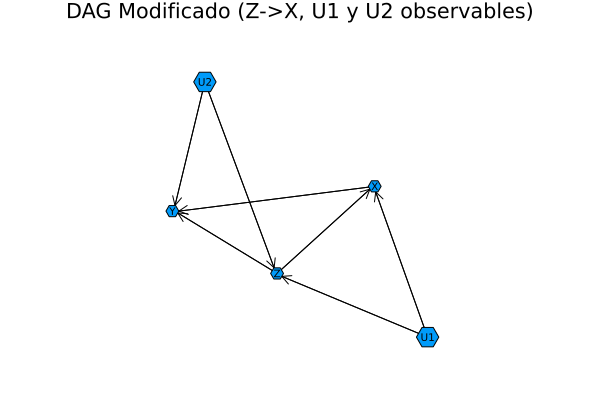

In [30]:
# --- 2. DAG Modificado con Controles Observables ---

println("\n\n--- PARTE 3.2: DAG Modificado y Búsqueda de Controles ---")

## 2.1 Grafo y Simulación del DAG Modificado
node_labels = ["U1", "U2", "X", "Y", "Z"]
nodes = Dict(l => i for (i, l) in enumerate(node_labels))

# Crear el grafo dirigido con 5 nodos
g_modificado = DiGraph(5)

# Añadir las flechas (bordes), incluyendo la nueva Z -> X
add_edge!(g_modificado, nodes["U1"], nodes["X"]); add_edge!(g_modificado, nodes["U1"], nodes["Z"]);
add_edge!(g_modificado, nodes["U2"], nodes["Y"]); add_edge!(g_modificado, nodes["U2"], nodes["Z"]);
add_edge!(g_modificado, nodes["X"], nodes["Y"]); add_edge!(g_modificado, nodes["Z"], nodes["Y"]);
add_edge!(g_modificado, nodes["Z"], nodes["X"]); # Flecha nueva

# Graficar usando Plots.jl (no se necesita estilo especial pues todos son observables)
Plots.plot(g_modificado, names=node_labels, curves=false, 
     title="DAG Modificado (Z->X, U1 y U2 observables)")


In [45]:
# Simulación donde U1 y U2 son observables
Random.seed!(111)
#REVISAR TRUE EFFECT VARIABLEEEEEEEEEEEEEEEEEEEE
U1 = randn(n_samples); 
U2 = randn(n_samples)
Z  = 1 * U1 .+ 1 * U2 .+ randn(n_samples)
X  = 1 * U1 .+ 1 * Z .+ randn(n_samples)
Y  = true_effect_modificado* X .+ 1 * Z .+ 1 * U2 .+ randn(n_samples)
df_modified = DataFrame(X=X, Y=Y, Z=Z, U1=U1, U2=U2)

df_modified = DataFrame(X=X, Y=Y, Z=Z, U1=U1, U2=U2)

Row,X,Y,Z,U1,U2
,Float64,Float64,Float64,Float64,Float64
1,-4.99102,-5.23082,-1.58981,-2.02716,0.763877
2,0.631512,0.236497,-0.356828,0.967376,-0.275604
3,-0.1906,0.977632,-0.359314,0.43725,-1.32667
4,0.0333299,-0.125779,-0.408623,0.1515,-0.422273
5,-0.475898,3.52265,0.40769,-0.203685,0.919522
6,4.63066,7.29001,1.93867,0.950401,0.99076
7,3.74586,3.24295,1.06055,0.594127,-0.344252
8,2.69165,2.62921,1.27691,0.96102,0.0297459
9,-3.52913,-6.07607,-2.21232,-2.15646,-0.617086


In [37]:
## 2.2 Correr las 8 Regresiones
formulas = [
    "NINGUNO"      => @formula(Y ~ 0 + X),
    "Z"         => @formula(Y ~ 0 + X + Z),
    "U1"        => @formula(Y ~ 0 + X + U1),
    "U2"        => @formula(Y ~ 0 + X + U2),
    "Z, U1"     => @formula(Y ~ 0 + X + Z + U1),
    "Z, U2"     => @formula(Y ~ 0 + X + Z + U2),
    "U1, U2"    => @formula(Y ~ 0 + X + U1 + U2),
    "Z, U1, U2" => @formula(Y ~ 0 + X + Z + U1 + U2)
]

results_list = []
for (controls, formula) in formulas
    model = lm(formula, df_modified)
    ct = coeftable(model)
    # Encontrar la fila correspondiente a 'X'
    x_row = findfirst(x -> x == "X", ct.rownms)
    beta = ct.cols[1][x_row]
    se = ct.cols[2][x_row]
    push!(results_list, (Controls=controls, β=beta, SE=se))
end
results_df = DataFrame(results_list)


Row,Controls,β,SE
,String,Float64,Float64
1,NINGUNO,1.71462,0.00221525
2,Z,0.800332,0.00309297
3,U1,2.00412,0.00316779
4,U2,1.49838,0.00157734
5,"Z, U1",1.00186,0.00388167
6,"Z, U2",1.00186,0.00257495
7,"U1, U2",1.50014,0.00273873
8,"Z, U1, U2",1.00208,0.00316406


In [ ]:
## 2.3 Presentar y Exportar la Tabla de Resultados
println("\n--- Tabla de Resultados: Escenario Modificado ---")
@printf "El efecto causal verdadero es: %.1f\n\n" true_effect_modificado
println(results_df)
CSV.write("output/regression_results_Julia.txt", results_df, delim='\t')
println("\n Tabla exportada a 'output/regression_results_Julia.txt'\n")


--- Tabla de Resultados: Escenario Modificado ---
El efecto causal verdadero es: 1.0

8×3 DataFrame
 Row │ Controls   β         SE         
     │ String     Float64   Float64    
─────┼─────────────────────────────────
   1 │ NINGUNO    1.71462   0.00221525
   2 │ Z          0.800332  0.00309297
   3 │ U1         2.00412   0.00316779
   4 │ U2         1.49838   0.00157734
   5 │ Z, U1      1.00186   0.00388167
   6 │ Z, U2      1.00186   0.00257495
   7 │ U1, U2     1.50014   0.00273873
   8 │ Z, U1, U2  1.00208   0.00316406

✅ Tabla exportada a 'output/regression_results_Julia.txt'



# --- 3. Análisis Final y Conclusiones ---


In [46]:
## 3.1 ¿Qué controles funcionan?}
# funcionan 3  Z, U1, U2 ;  Z, U2 ; Z, U1. 

# de manera automatica para que te lo brinde con codigo sería:
println("--- 3.1 ¿Qué controles funcionan? ---")
tolerance = 0.02
good_controls_df = filter(row -> abs(row.β - true_effect_modificado) < tolerance, results_df)
@printf "Modelos que estiman el efecto con una tolerancia de +/- %.2f:\n" tolerance
println(good_controls_df)

--- 3.1 ¿Qué controles funcionan? ---
Modelos que estiman el efecto con una tolerancia de +/- 0.02:
3×3 DataFrame
 Row │ Controls   β        SE         
     │ String     Float64  Float64    
─────┼────────────────────────────────
   1 │ Z, U1      1.00186  0.00388167
   2 │ Z, U2      1.00186  0.00257495
   3 │ Z, U1, U2  1.00208  0.00316406


In [47]:
## 3.2 ¿Cuál es el conjunto mínimo suficiente?
#son 2, Z y U2 o Z y U1, 

# pero si queremos que sea automatico con codigo, sería así:
println("\n--- 3.2 ¿Cuál es el conjunto mínimo suficiente? ---")
good_sets_list = [Set(split(c, ", ")) for c in good_controls_df.Controls]
minimal_sufficient_sets = []
for current_set in good_sets_list
    is_minimal = true
    for other_set in good_sets_list
        if current_set != other_set && issubset(other_set, current_set)
            is_minimal = false; break;
        end
    end
    if is_minimal; push!(minimal_sufficient_sets, current_set); end
end

println("El/Los conjunto(s) mínimo(s) suficiente(s) es/son:")
for s in minimal_sufficient_sets; println("- ", s); end


--- 3.2 ¿Cuál es el conjunto mínimo suficiente? ---
El/Los conjunto(s) mínimo(s) suficiente(s) es/son:
- Set(SubString{String}["Z", "U1"])
- Set(SubString{String}["Z", "U2"])


### Provide intuition on why you can get good estimates controlling for the variables you stablished abov
Para obtener una estimación correcta del efecto de X en Y, necesitamos cerrar todos los caminos de puerta trasera "backdoor path" que crean una conexión falsa entre ellos.

Observando el DAG, un primer impulso sería controlar por Z, ya que participa en varios de estos caminos. Sin embargo, Z es un collider en la ruta que conecta U1 y U2. Controlar por un collider es problemático porque abre este camino que antes estaba cerrado, creando un nuevo backdoor path espurio entre X y Y a través de U1 y U2.

La solución es usar el conjunto de controles {Z, U1}. Esta combinación funciona porque realiza dos acciones clave simultáneamente: el control sobre Z cierra los backdoor paths originales, mientras que el control sobre U1 cierra inmediatamente el nuevo camino que fue abierto por el colisionador. De esta manera, se neutralizan todas las conexiones espurias y se aísla el verdadero efecto causal de X sobre Y. Pasa similar  con {Z, U2}